# Multi-touch Multi-channel Attribution Model

Data description
This dataset represents a sample of 30 days of Criteo live traffic data. Each line corresponds to one impression (a banner) that was displayed to a user. For each banner we have detailed information about the context, if it was clicked, if it led to a conversion and if it led to a conversion that was attributed to Criteo or not. Data has been sub-sampled and anonymized so as not to disclose proprietary elements.

Here is a detailed description of the fields (they are tab-separated in the file):

- timestamp: timestamp of the impression (starting from 0 for the first impression). The dataset is sorted according to timestamp.
- uid: a unique user identifier
- campaign: a unique identifier for the campaign
- conversion: 1 if there was a conversion in the 30 days after the impression (independently of whether this impression was last click or not)
- conversion_timestamp: the timestamp of the conversion or -1 if no conversion was observed
- conversion_id: a unique identifier for each conversion (so that timelines can be reconstructed if needed). -1 if there was no conversion
- attribution: 1 if the conversion was attributed to Criteo, 0 otherwise
- click: 1 if the impression was clicked, 0 otherwise
- click_pos: the position of the click before a conversion (0 for first-click)
- click_nb: number of clicks. More than 1 if there was several clicks before a conversion
- cost: the price paid by Criteo for this display (disclaimer: not the real price, only a transformed version of it)
- cpo: the cost-per-order in case of attributed conversion (disclaimer: not the real price, only a transformed version of it)
- time_since_last_click: the time since the last click (in s) for the given impression
- cat(1-9): contextual features associated to the display. Can be used to learn the click/conversion models. We do not disclose the meaning of - these features but it is not relevant for this study. Each column is a categorical variable. In the experiments, they are mapped to a fixed - dimensionality space using the Hashing Trick (see paper for reference).

## Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle

#import keras

plt.style.use('ggplot')

In [5]:

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
    
## data_file = 'data/criteo_attribution_dataset.tsv.gz'
## df0 = pd.read_csv(data_file, sep='\t', compression='gzip')

test = pd.read_csv(r"F:\NeU 2nd Sem\ADM\Assignment 3\pcb_dataset_final.tsv", sep="\t")



In [12]:
n_campaigns = 100

df1 = add_derived_columns(test)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])


In [13]:

# Time Decay

df6['day'] = np.floor(test.timestamp / 86400.).astype(int) 
d = df6.groupby(['uid']).count()
df_converted_test = df6[df6['conversion'] == 1]
df6_max_day_dict = {}
for uid in df_converted_test['uid'].unique():
    df6_max_day_dict[uid] = df_converted_test[df_converted_test['uid'] == uid]['day'].max()


# LTA

In [14]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    print(campaign_impressions[0])
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
    print(campaign_conversions[0])
    print(df_converted[idx].head())
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)

54061.0
8413.0
       timestamp       uid  campaign conversion conversion_timestamp  \
167046      1024  11676091  15321102          1                 1321   
35484       1498  31851108  30801593          1                22475   
134709      1568  21556368   9100689          1                 1668   
159069      2426   3826466  30801593          1                 3664   
147654      2625   6751166  30801593          1               144355   

       conversion_id attribution click click_pos click_nb  ...      cat6  \
167046       2184732           1     1         4        5  ...  28928366   
35484       11232090           1     1        13       14  ...    138937   
134709      19900919           1     1         1        2  ...   5824239   
159069      23590675           1     1         1        2  ...   1973606   
147654      22581513           0     1         2        3  ...  29196072   

            cat7      cat8      cat9                jid timestamp_norm  \
167046  27594281  291

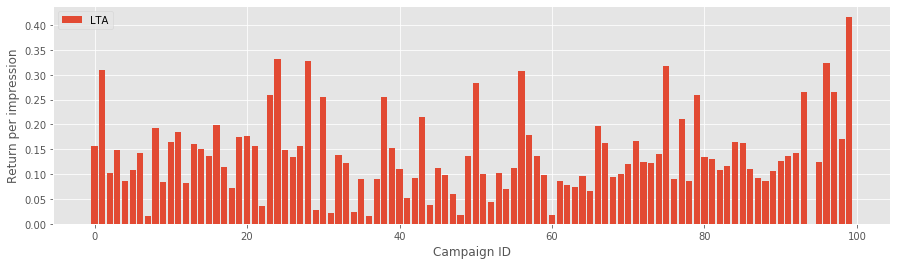

In [15]:

campaign_idx = range(0, 100)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()


# FTA

In [16]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    print(campaign_impressions[0])
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
    print(campaign_conversions[0])
    print(df_converted[idx].head())
        
    return campaign_conversions / campaign_impressions
    
fta = last_touch_attribution(df6)

54061.0
8413.0
       timestamp       uid  campaign conversion conversion_timestamp  \
223483         3   7306395  29427842          1              1449193   
113575       179  12139598  10341182          1               649097   
204247       465    120514   9100689          1               775991   
29399        630  14251669  10341182          1               712393   
56136        703  21556368   9100689          1                 1668   

       conversion_id attribution click click_pos click_nb  ...      cat6  \
223483       3063962           0     1         0        7  ...   1973606   
113575      20795639           1     1         1        5  ...   1973606   
204247      26234639           1     1         0        2  ...  29196072   
29399            325           1     1         8       10  ...   1973606   
56136       19900919           1     1         0        2  ...   5824239   

            cat7      cat8      cat9                jid timestamp_norm  \
223483   9180723  298

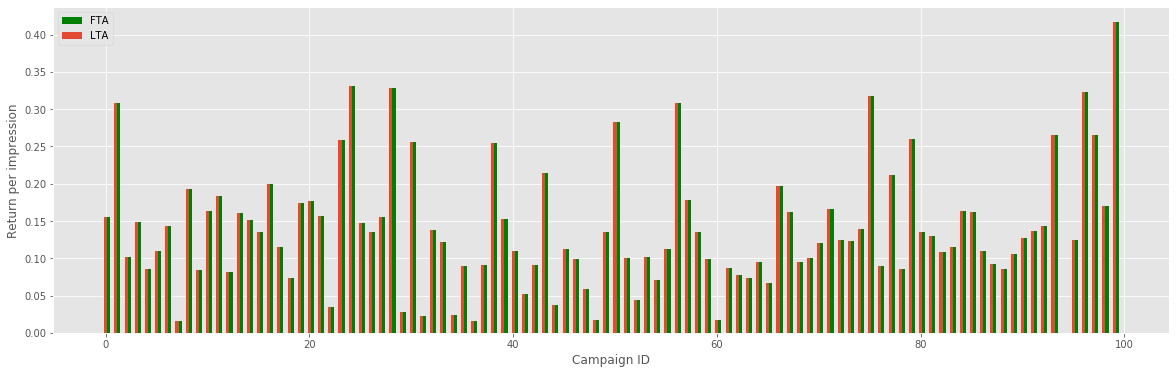

In [17]:
campaign_idx = range(0, 100)


fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
plt.bar( np.arange(len(fta[campaign_idx])) + 0.3, fta[campaign_idx], width=0.3, label='FTA',color="g" )
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], width=0.3, label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Linear Attribution model

In [18]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    print(campaign_impressions[0])
    
    df_converted = df[df['conversion'] == 1]
    #idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted)
    print(campaign_conversions[0])
    #print(df_converted[idx].head())
        
    return campaign_conversions / campaign_impressions
    
lam = last_touch_attribution(df6)

54061.0
32015.0


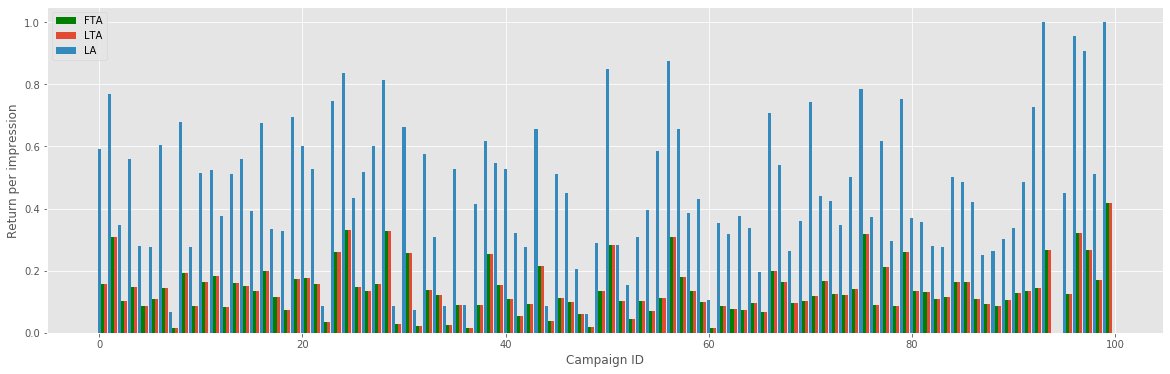

In [19]:
campaign_idx = range(0, 100)


fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
plt.bar( np.arange(len(fta[campaign_idx])) + 0.3, fta[campaign_idx], width=0.3, label='FTA',color="g" )
plt.bar( np.arange(len(lta[campaign_idx])) + 0.6, lta[campaign_idx], width=0.3, label='LTA' )
plt.bar( range(len(lam[campaign_idx])), lam[campaign_idx], width=0.3, label='LA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# U-Shaped Attribution Model

In [20]:
def UShaped_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    print(campaign_impressions[0])
    
    df_converted = df[df['conversion'] == 1]
    idx_min = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversion_min = count_by_campaign(df_converted[idx_min]) * 0.4
    print(campaign_conversion_min[1])
    
    idx_max = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversion_max = count_by_campaign(df_converted[idx_max]) * 0.4
    print(campaign_conversion_max[1])
    #print(df_converted[idx].head())
    
    g = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) != df_converted['timestamp_norm']
    dfc1 = df_converted[g]
    g1 = dfc1.groupby(['jid'])['timestamp_norm'].transform(max) != dfc1['timestamp_norm']
    campaign_conversion = count_by_campaign(dfc1[g1]) * 0.2
    print(campaign_conversion[1])
    
    final_campaign_conversion = campaign_conversion_min + campaign_conversion_max + campaign_conversion
        
    return final_campaign_conversion / campaign_impressions
    
usa = UShaped_attribution(df6)
usa

54061.0
538.4
538.4
132.4


array([0.18068848, 0.27746673, 0.11005147, 0.17116187, 0.08994775,
       0.09890909, 0.1778155 , 0.01955307, 0.21270937, 0.08934328,
       0.16817102, 0.17852941, 0.10759664, 0.16694215, 0.17230863,
       0.13242961, 0.21499293, 0.11292876, 0.09453768, 0.20869565,
       0.19090909, 0.1684438 , 0.031     , 0.25276701, 0.29939051,
       0.14599156, 0.15757176, 0.18261851, 0.29396602, 0.02893511,
       0.23501427, 0.02351558, 0.17041801, 0.11002132, 0.0266289 ,
       0.14151369, 0.02446043, 0.11909722, 0.22541966, 0.1703125 ,
       0.14933993, 0.08497284, 0.09160165, 0.21730769, 0.03241895,
       0.14752688, 0.12921665, 0.06487648, 0.01893831, 0.11186441,
       0.28318584, 0.09689922, 0.04850615, 0.10213836, 0.10702875,
       0.16168224, 0.29807692, 0.20285714, 0.13168724, 0.1255113 ,
       0.02808511, 0.10561798, 0.09485179, 0.10460123, 0.10588235,
       0.06566524, 0.22077922, 0.17279188, 0.09033613, 0.1121447 ,
       0.19692308, 0.15456674, 0.13482143, 0.11864407, 0.15588

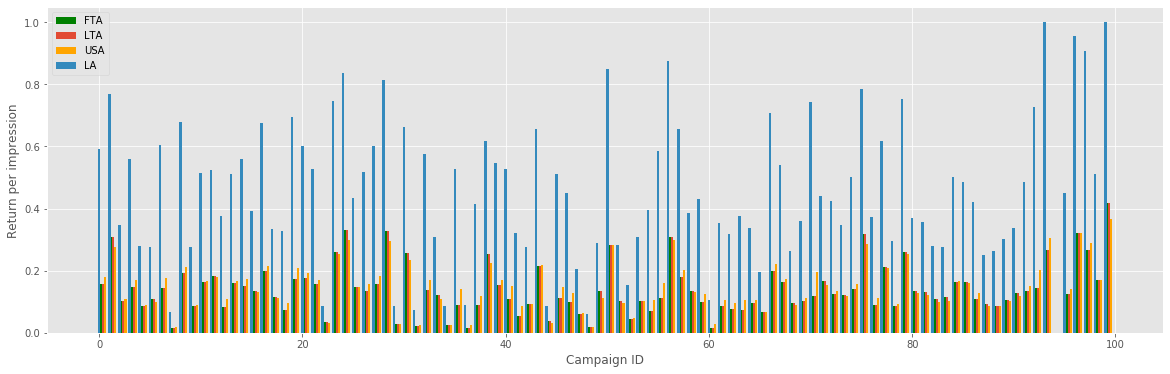

In [21]:
campaign_idx = range(0, 100)


fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
plt.bar( np.arange(len(fta[campaign_idx])) + 0.2, fta[campaign_idx], width=0.2, label='FTA',color="g" )
plt.bar( np.arange(len(lta[campaign_idx])) + 0.4, lta[campaign_idx], width=0.2, label='LTA' )
plt.bar( np.arange(len(usa[campaign_idx])) + 0.6, usa[campaign_idx], width=0.2, label='USA',color="orange" )
plt.bar( range(len(lam[campaign_idx])), lam[campaign_idx], width=0.25, label='LA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

# Time Decay Attribution model

In [22]:

#Time Decay
def time_decay_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    def count_by_timedecay_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot, day, uid in zip(df['campaigns'].values, df['day'].values, df['uid'].values):
            campaign_id = np.argmax(campaign_one_hot)
            time_decay_coefficient = 2**(-(df6_max_day_dict[uid] - day)/7)
            counters[campaign_id] = counters[campaign_id] + time_decay_coefficient
        return counters
    
    df_converted = df[df['conversion'] == 1]
    campaign_conversions = count_by_timedecay_campaign(df_converted)
        
    return campaign_conversions / campaign_impressions
    
tdta = time_decay_touch_attribution(df6)

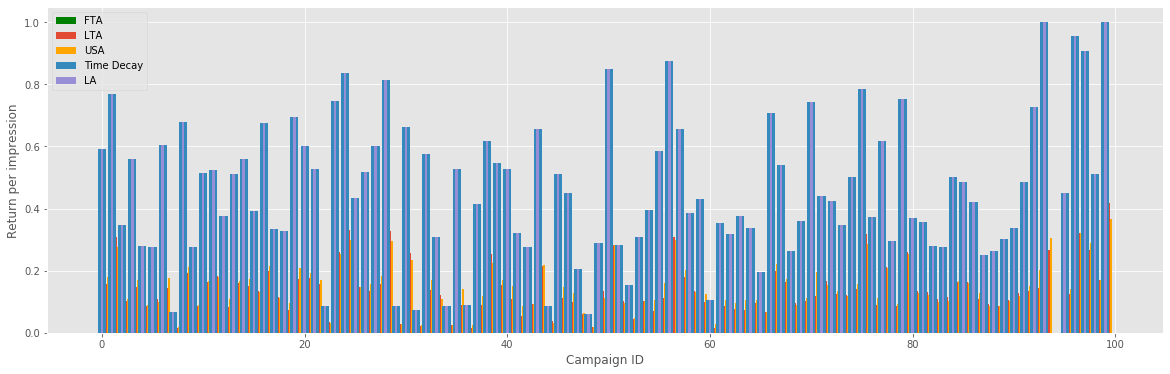

In [24]:
campaign_idx = range(0, 100)


fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(111)
plt.bar( np.arange(len(fta[campaign_idx])) + 0.2, fta[campaign_idx], width=0.2, label='FTA',color="g" )
plt.bar( np.arange(len(lta[campaign_idx])) + 0.4, lta[campaign_idx], width=0.2, label='LTA' )
plt.bar( np.arange(len(usa[campaign_idx])) + 0.6, usa[campaign_idx], width=0.2, label='USA',color="orange" )
plt.bar( np.arange(len(tdta[campaign_idx])), tdta[campaign_idx], label='Time Decay' )
plt.bar( range(len(lam[campaign_idx])), lam[campaign_idx], width=0.25, label='LA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

C:\Users\Win10\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


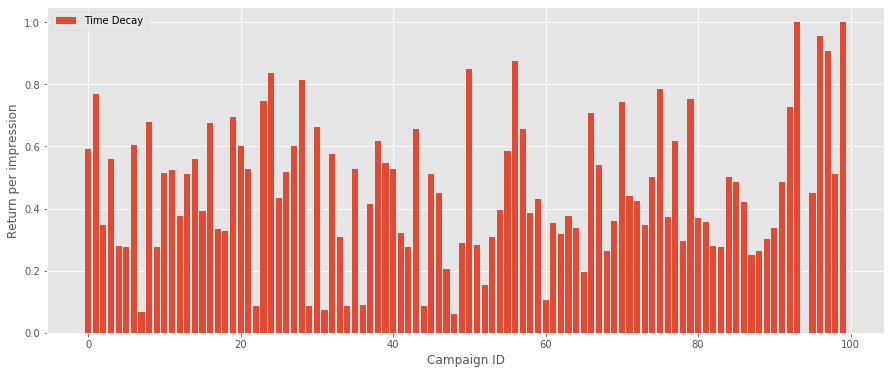

In [25]:
campaign_id = range(0, 100)

fig3 = plt.figure(figsize=(15,6))
ax3 = fig.add_subplot(111)
plt.bar( range(len(tdta[campaign_id])), tdta[campaign_id], label='Time Decay' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')

## Simulation

In [28]:
# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns

def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [30]:
pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
attributions = [lta, fta, lam, tdta, usa]
r = []

for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch)
        print('{} {} : {}'.format(pitch, j, reward))
        r.append(reward)

0.1 0 : 418
0.1 1 : 418
0.1 2 : 411
0.25 0 : 436
0.25 1 : 436
0.25 2 : 431
0.5 0 : 454
0.5 1 : 454
0.5 2 : 435
1.0 0 : 482
1.0 1 : 482
1.0 2 : 432
1.5 0 : 492
1.5 1 : 492
1.5 2 : 427
2.0 0 : 517
2.0 1 : 517
2.0 2 : 425
2.5 0 : 555
2.5 1 : 555
2.5 2 : 433
3.0 0 : 608
3.0 1 : 608
3.0 2 : 432


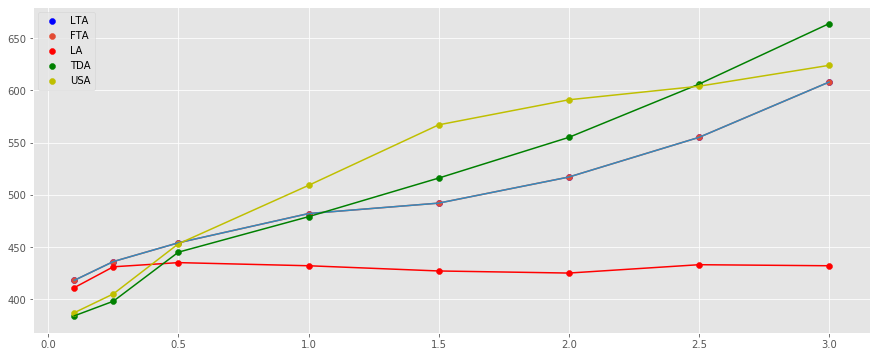

In [44]:
plt.figure(figsize=(15,6))
plt.scatter([0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [418,436,454,482,492,517,555,608], c="b", label = "LTA")
plt.plot([0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [418,436,454,482,492,517,555,608])

plt.scatter([0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [418,436,454,482,492,517,555,608], label = "FTA")
plt.plot([0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [418,436,454,482,492,517,555,608])

plt.scatter([0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [411,431,435,432,427,425,433,432], c="r", label = "LA")
plt.plot([0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [411,431,435,432,427,425,433,432], c="r")

##TDA
plt.scatter([0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [384,398,445,479,516,555,606,664], c="g", label = "TDA")
plt.plot([0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [384,398,445,479,516,555,606,664], c="g")

##USA
plt.scatter([0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [387,405,453,509,567,591,604,624], c="y", label = "USA")
plt.plot([0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0], [387,405,453,509,567,591,604,624], c="y")

plt.legend()